# Real Time Eye Gaze Tracking with Kinect


In [2]:
from PIL import Image
import cv2
import numpy as np
import os
import json
import pandas as pd
import bson
from tqdm import tqdm
from pprint import pprint
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

import sys
sys.path.append('../')

from brspy.export import GazesExport
from brspy.export import MimicsExport
from brspy.export import JointsExport
from brspy.export import JointOrientationsExport
from brspy.export import FacePropertiesExport

from brspy.reader import Session
from brspy.export.utils import *

from devices import Camera
from devices import Device

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

## Configuration

In [3]:
markers_path = r'./markers.json'
# datasets_path = r"./datasets/07_08_18"
datasets_path = r"D:/datasets-calibration/07_08_18"
sess_path = os.path.join(datasets_path, '1533638926')
cam_data_path = r'./cam_data.json'

with open(markers_path, 'r') as f:
    markers_db = json.load(f)
    
with open(cam_data_path, 'r') as f:
    cam_data = json.load(f)
    
class HDFace:
    
    LefteyeInnercorner = '210'
    LefteyeOutercorner = '469'
    LefteyeMidtop = '241'
    LefteyeMidbottom = '1104'
    RighteyeInnercorner = '843'
    RighteyeOutercorner = '1117'
    RighteyeMidtop = '731'
    RighteyeMidbottom = '1090'
    LefteyebrowInner = '346'
    LefteyebrowOuter = '140'
    LefteyebrowCenter = '222'
    RighteyebrowInner = '803'
    RighteyebrowOuter = '758'
    RighteyebrowCenter = '849'
    MouthLeftcorner = '91'
    MouthRightcorner = '687'
    MouthUpperlipMidtop = '19'
    MouthUpperlipMidbottom = '1072'
    MouthLowerlipMidtop = '10'
    MouthLowerlipMidbottom = '8'
    NoseTip = '18'
    NoseBottom = '14'
    NoseBottomleft = '156'
    NoseBottomright = '783'
    NoseTop = '24'
    NoseTopleft = '151'
    NoseTopright = '772'
    ForeheadCenter = '28'
    LeftcheekCenter = '412'
    RightcheekCenter = '933'
    Leftcheekbone = '458'
    Rightcheekbone = '674'
    ChinCenter = '4'
    LowerjawLeftend = '1307'
    LowerjawRightend = '1327'
    
    @classmethod
    def items(cls):
        return {attr_name: getattr(cls, attr_name)
                for attr_name in dir(cls) if not attr_name.startswith('__') and not callable(getattr(cls, attr_name))}
    
    @classmethod
    def values(cls):
        return [value for key, value in cls.items().items()]
    
    @classmethod
    def keys(cls):
        return [key for key, value in cls.items().items()]
    
EyeRightCircleIdx = [776,  777,  846,  843,  1098, 
                     1097,  1095,  1096,  1096,  1091, 
                     1090,  1092,  1099,  1094,  1093, 
                     1100,  1101,  1102,  1117,  1071, 
                     1012,  992,  987,  752,  749, 
                     876,  733,  731,  728]
EyeLeftCircleIdx = [210, 316, 187, 153, 121,
                    241, 244, 238, 137, 211,
                    188, 287, 440, 1116, 469,
                    1115, 1114, 1113, 1107, 1106,
                    1112, 1105, 1104, 1103, 1108,
                    1109, 1111, 1110]

hd_all = list(map(str, range(0, 1347)))

avg_eye_radius = 0.007462746808244293

### Utils

In [4]:
from scipy.optimize import minimize


class Intersection:
    
    def __init__(self, cam_point, eye_radius, alpha=0.0001, tol=None):
        
        # model parameters
        self.eye_radius = eye_radius
        self.alpha = alpha
        self.tol = tol
        
        # points in 3d
        self.cam_point = cam_point
        self.eye_center = None
        self.ray_point = None
        
        
    def cost(self, point):
        
        # point must be on sphere surface
        sphere_cost = np.abs(np.sum((point - self.eye_center) ** 2) - (self.eye_radius ** 2))
        
        # point must be on line
        line_eq_components = (point - self.cam_point) / (self.ray_point - self.cam_point)
#         print(sphere_cost)
        line_cost = np.sum(np.abs(np.diff((point - self.cam_point) / (self.ray_point - self.cam_point))))
        
        # to prevent 2 point intersection ambiguity
        regularization = np.linalg.norm(point)
        
        # sum of all costs
        return sphere_cost ** 2 + line_cost ** 2 + sphere_cost * line_cost + self.alpha * regularization
    
    def find(self, eye_center, ray_point, verbose=True):
        
        # assign points
        self.eye_center = eye_center
        self.ray_point = ray_point
        
        # try minimize
        result = minimize(self.cost, x0=self.eye_center - self.ray_point, tol=self.tol)
        
        # print message
        if verbose:
            print(f'Cost: {result.fun:.2e}. ', result.message, sep='')
            
        return result.x
    
    def np_find(self, arr):
        return self.find(eye_center=arr[:3], ray_point=arr[3:], verbose=False)
    
    
def add_dummy_z(arr_2d):
    return np.column_stack((arr_2d, np.full(arr_2d.shape[0], 1))) 

def to_tuple(dct):
    return tuple(int(item) for key, item in dct.items())

def extract_rectangle(img, pt0, pt1):
    return img[pt0[1]:pt1[1], pt0[0]:pt1[0]]

def dict_to_np(dict_data):
    return np.array([value for axis, value in dict_data.items()]).reshape(-1, len(dict_data))

def add_dummy_z(arr_2d):
    if isinstance(arr_2d, dict):
        arr_2d = dict_to_np(arr_2d)
    return np.column_stack((arr_2d, np.full(arr_2d.shape[0], 1))) 

### Cameras 

In [5]:
for cam_name, data_dict in cam_data.items():
    Camera(cam_name, **data_dict)
    
KinectColor = Camera.get('KinectColor')
WebCamera = Camera.get('WebCamera')
InfraredCamera = Camera.get('InfraredCamera')
KinectInfrared = Camera.get('KinectInfrared')

### write markers to session

In [6]:
def to_json(vector):
    return {axis: value for axis, value in zip('XYZ', vector)}

# choose only wall 0
markers_wall_0 = {key: value for key, value in markers_db.items() if key.split('_')[1] == '0'}
pprint(markers_wall_0)

markers_save = os.path.join(sess_path, 'DataSource', 'cam_101')

try:
    os.mkdir(markers_save)
except:
    pass

counter = 0
for i in range(5):
    for j in range(8):
        marker = markers_wall_0.get(f'wall_{0}_dot_{j+1}')
        if marker:
            file_name = os.path.join(markers_save, str(counter).rjust(5, '0') + '.txt')
            with open(file_name, 'w') as f:
                json.dump(to_json(marker), f)
            counter += 1

{'wall_0_dot_1': [1.2878455803398767, -1.4462872524020634, -2.0433796750522086],
 'wall_0_dot_2': [0.3235454220662274, -1.4403578997805284, -2.0905758046738723],
 'wall_0_dot_3': [-0.4954355512992749,
                  -1.4353220953790173,
                  -2.1306595191117434],
 'wall_0_dot_4': [-1.5241555544291134,
                  -1.4289966337527293,
                  -2.1810085750519956],
 'wall_0_dot_5': [1.2919249781934634, -0.4471771977434076, -2.0018112330072593],
 'wall_0_dot_6': [0.32762481991981407,
                  -0.44124784512187254,
                  -2.0490073626289234],
 'wall_0_dot_7': [-0.4913561534456882, -0.4362120407203617, -2.089091077066794],
 'wall_0_dot_8': [-1.5200761565755267,
                  -0.42988657909407363,
                  -2.1394401330070463]}


## Create session

In [7]:
sess = Session(sess_path)

avoid = [
#     'KinectDepth',
#     'KinectInfrared',
#     'KinectBodyIndex',
#     'KinectColor',
#     'KinectBody',
#     'KinectFaceVertices',
#     'GazeEstimation',
#     'WebCamera',
#     'InfraredCamera',
#     'Markers'
]

sess.remove_devices(*avoid)

### analyse snapshot

In [8]:
class PersonCalibration:
    
    default_parameters = np.array([0.0, 0.0, avg_eye_radius, avg_eye_radius/2, -0.03,  0.03, 0.05])
    
    def __init__(self, name='person', parameters=None):
        
        self.name = name
        
        # person parameters
        self.parameters = np.array(parameters) if parameters else self.default_parameters

    @property
    def parameters(self):
        self._parameters = None
    
    @parameters.getter
    def parameters(self):
        return self._parameters
    
    @parameters.setter
    def parameters(self, value):
        self._parameters = value
        
#         print(f'Set parameters to: {value}')
        
        # person parameters links
        self.visual_angles = self.parameters[:2].reshape(1, 2)
        self.eye_radius = self.parameters[2]
        self.cornea_radius = self.parameters[3]
        self.eye_center_head = self.parameters[4:7].reshape(1, 3)
        
    def calculate_eye_center(self, rotation, translation):
        """
        rotation (1, 3)
        translation (1, 3)

        parameters
        eye_center_head (1, 3)
        """
        # (Rodrigues((1, 3)) -> (3, 3))
        rotation_matrix = cv2.Rodrigues(rotation)[0]

        # ((3, 3) @ (3, 1) + (1, 3).T).T -> (1, 3)
        return (rotation_matrix @ self.eye_center_head.T + translation.T).T
    
    def calculate_optical_axis(self, pupil_center, eye_center):
        # ((1, 3) - (1, 3)) / scalar -> optical axis (1, 3)
        return (pupil_center - eye_center) / np.linalg.norm(pupil_center - eye_center)
    
    def calculate_cornea_center(self, eye_center, optical_axis):
        # (1, 3) + scalar * (1, 3) -> (1, 3)
        return eye_center + self.cornea_radius * optical_axis
    
    def calculate_visual_axis(self, optical_axis):
        # (((1, 3) -> (1, 2)) + (1, 2)) -> (1, 3)
        visual_axis = angles2vecs(vecs2angles(optical_axis) + self.visual_angles)
        
        # norm vector
        return visual_axis / np.linalg.norm(visual_axis)
    
    def calculate_eye_geometry(self, pupil_center, rotation, translation):
        
        eye_center = self.calculate_eye_center(rotation, translation)
        optical_axis = self.calculate_optical_axis(pupil_center, eye_center)
        cornea_center = self.calculate_cornea_center(eye_center, optical_axis)
        visual_axis = self.calculate_visual_axis(optical_axis)
        
        return cornea_center, visual_axis
    
    def gaze_direction(self, pupil_center, rotation, translation, coeff=3):
        """
        pupil_center (1, 3)
        rotation (1, 3)
        translation (1, 3)

        parameters
        eye_center_head (1, 3)
        cornea_radius scalar
        """
        cornea_center, visual_axis = self.calculate_eye_geometry(pupil_center, rotation, translation)
        
        return np.array([cornea_center.flatten(), (cornea_center + coeff * visual_axis).flatten()])
    
    def calibrate(self, points, pupil_centers, rotations, translations, alpha=1e-2):
        
        arr = np.column_stack((points, pupil_centers, rotations, translations))

        def cost(parameters):
            
            self.parameters = parameters
            
            loss = 0
            
            for s in arr:
                
                point = s[:3].reshape(1, 3)
                pupil_center, rotation, translation = s[3:6].reshape(1, 3), s[6:9].reshape(1, 3), s[9:12].reshape(1, 3)
                
                cornea_center, visual_axis = self.calculate_eye_geometry(pupil_center, rotation, translation)
                
                gaze_vector_true = point - cornea_center
                gaze_vector_true = gaze_vector_true / np.linalg.norm(gaze_vector_true)
                
                loss += np.sum((gaze_vector_true - visual_axis) ** 2) + alpha * np.linalg.norm(self.eye_center_head) ** 2
            
            return loss
        
        constraints = [
            # eye radius
            {'type': 'ineq', 'fun': lambda x: avg_eye_radius * 0.7 - x[2]},
            {'type': 'ineq', 'fun': lambda x: x[2] - avg_eye_radius * 1.3},
            
            # cornea radius
            {'type': 'ineq', 'fun': lambda x: x[2] - x[3]},
            {'type': 'ineq', 'fun': lambda x: x[3] - x[2] / 4},
            
            # visual axis angles
            {'type': 'ineq', 'fun': lambda x: x[0] - np.deg2rad(5)},
            {'type': 'ineq', 'fun': lambda x: np.deg2rad(5) - x[0]},
            {'type': 'ineq', 'fun': lambda x: x[1] - np.deg2rad(5)},
            {'type': 'ineq', 'fun': lambda x: np.deg2rad(5) - x[1]},
            
            # eye center head
            {'type': 'ineq', 'fun': lambda x: abs(x[4]) - 0.05},
            {'type': 'ineq', 'fun': lambda x: x[5] - 0.05},
            {'type': 'ineq', 'fun': lambda x: x[6] - 0.07},
            {'type': 'ineq', 'fun': lambda x: 0.05 - abs(x[4])},
            {'type': 'ineq', 'fun': lambda x: 0.05 - x[5]},
            {'type': 'ineq', 'fun': lambda x: 0.07 - x[6]},
            
        ]
        minimized = minimize(cost, x0=self.parameters, constraints=constraints, method='SLSQP')
        
        return minimized
        

In [9]:
img = np.copy(snapshot.InfraredCamera[:, ::-1, ::-1])
img = (img / img.max() * 255).astype('uint8')

pts_2d = InfraredCamera.project_vectors(face_points[list(map(int, HDFace.values()))]).astype('float64').astype(int)
pupil_test = InfraredCamera.project_vectors(pupil_3d.astype('float64')).astype(int)
nose_2d = InfraredCamera.project_vectors(face_points[int(HDFace.NoseTip)].reshape(1, 3)).astype(int)

for pt_2d in pts_2d:
    cv2.circle(img, tuple(pt_2d), 1, (255, 0, 0), -1)
cv2.circle(img, tuple(pupil_test[0].astype(int)), 1, (0, 0, 255), -1)
cv2.circle(img, tuple(pupil_center_2d[0].astype(int)), 1, (0, 255, 0))
cv2.circle(img, tuple(nose_2d[0].astype(int)), 3, (0, 0, 255), )


Image.fromarray(img)

NameError: name 'snapshot' is not defined

In [386]:
face_points - InfraredCamera.vectors_to_origin(InfraredCamera.vectors_to_self(face_points))

array([[ 0.00000000e+00, -6.93889390e-18,  0.00000000e+00],
       [ 0.00000000e+00,  6.93889390e-18,  0.00000000e+00],
       [ 0.00000000e+00,  6.93889390e-18,  2.22044605e-16],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  2.22044605e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16]])

In [ ]:
np.ta

In [426]:
x = 1.0
y = 0.0
z = 0.0
w = 1.0

q = Quaternion(w, x, y, z)

# // convert face rotation quaternion to Euler angles in degrees      
dPitch = np.arctan2(2 * (y * z + w * x), w * w - x * x - y * y + z * z)
dYaw = np.arcsin(2 * (w * y - x * z))
dRoll = np.arctan2(2 * (x * y + w * z), w * w + x * x - y * y - z * z)
print(q.yaw_pitch_roll)
print(dYaw, dPitch, dRoll)

(0.0, 0.0, 1.5707963267948963)
0.0 1.5707963267948966 0.0


In [427]:
from pyquaternion import Quaternion

print(q.rotation_matrix)
dir(q)

[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]


['__add__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ipow__',
 '__isub__',
 '__itruediv__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_fast_normalise',
 '_from_axis_angle',
 '_from_matrix',
 '_normalise',
 '_q_bar_matrix',
 '_q_matrix',
 '_rotate_quaternion',
 '_sum_of_squares',
 '_validate_number_sequence',
 '_vector_conjugate',
 '_wrap_angle',
 'absolute_dis

In [261]:
def quaternion_to_rotation(quaternion):
    """
    Converts angle-axis to quaternion
    :param quaternion: dict {'X': , 'Y': , 'Z': , 'W': }
    :return: angle-axis rotation vector
    """
    if isinstance(quaternion, dict):
        quaternion = dict_to_np(quaternion).flatten()
        
    assert quaternion.ndim == 1
    assert quaternion.shape == (4,)
    
    t = np.sqrt(1 - quaternion[-1] ** 2)
    
    if t:
        return (quaternion[:3] / t)
    else:
        return np.zeros((3,))

def estimate_face_points_3d(snapshot, camera, cam_resolution_x=1296):
    
    pipe_left = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    pipe_right = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    
    # get face points
    face_points = np.array([dict_to_np(snapshot.KinectFaceVertices[idx]).flatten() for idx in hd_all])
    face_points = face_points * flip_array
    
    # get eye circle points
    EyeLeftCircle = InfraredCamera.vectors_to_self(face_points[EyeLeftCircleIdx])
    EyeRightCircle = InfraredCamera.vectors_to_self(face_points[EyeRightCircleIdx])
    
    # get pupil center on 2D image
    pupil_left_2d = dict_to_np(snapshot.ManualPupils['pupilCenterLeft'])
    pupil_right_2d = dict_to_np(snapshot.ManualPupils['pupilCenterRight'])
    
    # get roi points of eye
    roi_left = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiLeft']])
    roi_right = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiRight']])
    
    # flip x-coordinate of 2D coordinates because of mirrored image
    pupil_left_2d[0, 0] = cam_resolution_x - pupil_left_2d[0, 0]
    pupil_right_2d[0, 0] = cam_resolution_x - pupil_right_2d[0, 0]
    roi_left[:, 0] = cam_resolution_x - roi_left[:, 0]
    roi_right[:, 0] = cam_resolution_x - roi_right[:, 0]
    
    # calculate relative position of pupil center on 2D image
    relative_pupil_left_2d = (pupil_left_2d - roi_left[0]) / np.diff(roi_left, axis=0)
    relative_pupil_right_2d = (pupil_right_2d - roi_right[0]) / np.diff(roi_right, axis=0)
    relative_pupil_left_2d[0, 0] = 1 - relative_pupil_left_2d[0, 0] 
    relative_pupil_right_2d[0, 0] = 1 - relative_pupil_right_2d[0, 0] 
    
    # estimate eye surface
    left_XY = EyeLeftCircle[:, :2]
    left_Z = EyeLeftCircle[:, 2]
    right_XY = EyeRightCircle[:, :2]
    right_Z = EyeRightCircle[:, 2]
    
    pipe_left.fit(left_XY, left_Z)
    pipe_right.fit(right_XY, right_Z)
    
    # get eye corners, top and mid points
    # and transit to Interested Camera coordinate system
    left_inner = camera.vectors_to_self(face_points[int(HDFace.LefteyeInnercorner)].reshape(1, 3)).flatten()
    left_outer = camera.vectors_to_self(face_points[int(HDFace.LefteyeOutercorner)].reshape(1, 3)).flatten()
    left_midtop = camera.vectors_to_self(face_points[int(HDFace.LefteyeMidtop)].reshape(1, 3)).flatten()
    left_midbot = camera.vectors_to_self(face_points[int(HDFace.LefteyeMidbottom)].reshape(1, 3)).flatten()
    
    right_inner = camera.vectors_to_self(face_points[int(HDFace.RighteyeInnercorner)].reshape(1, 3)).flatten()
    right_outer = camera.vectors_to_self(face_points[int(HDFace.RighteyeOutercorner)].reshape(1, 3)).flatten()
    right_midtop = camera.vectors_to_self(face_points[int(HDFace.RighteyeMidtop)].reshape(1, 3)).flatten()
    right_midbot = camera.vectors_to_self(face_points[int(HDFace.RighteyeMidbottom)].reshape(1, 3)).flatten()
    
    # get roi points X and Y in 3D in Interested Camera coordinate system
    left_top = np.array([left_inner[0], left_midtop[1]])
    left_bot = np.array([left_outer[0], left_midbot[1]])
    
    right_bot = np.array([right_inner[0], right_midbot[1]])
    right_top = np.array([right_outer[0], right_midtop[1]])
    
    # get size of roi 3 roi
    left_size_xy = np.abs(left_top - left_bot)
    right_size_xy = np.abs(right_top - right_bot)

    # estimate X and Y of 3D pupilcenter
    pupil_left_XY = left_top + relative_pupil_left_2d * left_size_xy
    pupil_right_XY = right_top + relative_pupil_right_2d * right_size_xy
    
    # estimate Z of 3D pupil_center
    pupil_left_Z = pipe_left.predict(pupil_left_XY)
    pupil_left_XYZ = np.column_stack((pupil_left_XY, pupil_left_Z))
    
    pupil_right_Z = pipe_right.predict(pupil_right_XY)
    pupil_right_XYZ = np.column_stack((pupil_right_XY, pupil_right_Z))
    
    # return pupil_center to origin coordinate system
    pupil_left_center = camera.vectors_to_origin(pupil_left_XYZ)
    pupil_right_center = camera.vectors_to_origin(pupil_right_XYZ)
    
    return face_points, pupil_left_center, pupil_right_center

def vectors_to(vectors, rotations, translations, to='self'):
    
    arr = zip(vectors, rotations, translations)

    if to is 'self':
        return np.array([(np.linalg.inv(cv2.Rodrigues(R)[0]) @ (V - T).reshape(3, 1)).flatten() for V, R, T in arr])
    elif to is 'origin':
        return np.array([(cv2.Rodrigues(R)[0] @ V.reshape(3, 1) + T.reshape(3, 1)).flatten() for V, R, T in arr])

In [434]:
markers = []
left_pupil_centers = []
right_pupil_centers = []
rotations, translations = [], []
left_gazes_true = []
left_gazes_true_person = []
right_gazes_true = []
right_gazes_true_person = []
face_points_array = []

pipe_left = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
pipe_right = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))

frames = []

flip_array = np.array([-1, -1, 1])

for snapshot in sess.snapshots_iterate(40, verbose=True):
    
    # get pupil and face points
    face_points, left_pupil_center, right_pupil_center = estimate_face_points_3d(snapshot, InfraredCamera)
    
    # get translation and rotation of head
    translation = dict_to_np(snapshot.KinectBody['0']['Joints']['Head']['Position']).flatten() * flip_array
#     rotation = quaternion_to_rotation(snapshot.KinectFace[0]['FaceRotationQuaternion']) #* np.array([1, 1, 1])
    q = snapshot.KinectFace[0]['FaceRotationQuaternion']
    q = Quaternion(q['W'], q['X'], q['Y'], q['Z'])
    rotation = cv2.Rodrigues(q.rotation_matrix)[0].flatten() #* np.array([1, 1, 1])
    
    # get marker
    marker = dict_to_np(snapshot.Markers) 
    
    # create person device
    person = Device(name='person', translation=translation.tolist(), rotation=rotation.tolist())
    
    # calculate true gaze
    left_gaze_true = marker - left_pupil_center
    right_gaze_true = marker - right_pupil_center
    
    # normalize gazes
    left_gaze_true = left_gaze_true / np.linalg.norm(left_gaze_true)
    right_gaze_true = right_gaze_true / np.linalg.norm(right_gaze_true)
    
    # calculate true gaze in person coordinate system
    left_gaze_true_person = person.vectors_to_self(marker) - person.vectors_to_self(left_pupil_center)
    right_gaze_true_person = person.vectors_to_self(marker) - person.vectors_to_self(right_pupil_center)
    
    # normalize gazes
    left_gaze_true_person = left_gaze_true_person / np.linalg.norm(left_gaze_true_person)
    right_gaze_true_person = right_gaze_true_person / np.linalg.norm(right_gaze_true_person)
    
    ### append data ###
    
    # pupils
    left_pupil_centers.append(left_pupil_center.flatten())
    right_pupil_centers.append(right_pupil_center.flatten())
    
    # head position
    rotations.append(rotation)
    translations.append(translation)
    
    # markers
    markers.append(marker.flatten())
    
    # gazes
    left_gazes_true.append(left_gaze_true.flatten())
    left_gazes_true_person.append(left_gaze_true_person.flatten())
    
    right_gazes_true.append(right_gaze_true.flatten())
    right_gazes_true_person.append(right_gaze_true_person.flatten())
    face_points_array.append(face_points)
    
    # face vector for visualization
    faceGaze = np.array([translation.flatten(), (translation - 4 * rotation).flatten()])
    
left_pupil_centers = np.array(left_pupil_centers)
right_pupil_centers = np.array(right_pupil_centers)

rotations = np.array(rotations)
translations = np.array(translations)
markers = np.array(markers)

left_gazes_true = np.array(left_gazes_true)
left_gazes_true_person = np.array(left_gazes_true_person)
right_gazes_true = np.array(right_gazes_true)
right_gazes_true_person = np.array(right_gazes_true_person)
face_points_array = np.array(face_points_array)

right_gazes_true - vectors_to(right_gazes_true_person, rotations, translations, to='origin')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.71it/s]


array([[-0.10998881,  0.09463916, -1.5161922 ],
       [-0.10995372,  0.09376961, -1.51692438],
       [-0.11008359,  0.09412708, -1.51740873],
       [-0.11016627,  0.09445563, -1.51765895],
       [-0.11119209,  0.09406175, -1.51750493],
       [-0.11147373,  0.09484565, -1.51734972],
       [-0.11136822,  0.09423678, -1.51746154],
       [-0.11190747,  0.09391267, -1.51706481],
       [-0.11505981,  0.09526127, -1.44657421],
       [-0.11523415,  0.09478977, -1.44702685],
       [-0.11709364,  0.09422253, -1.44809675],
       [-0.11933431,  0.09351211, -1.44780707],
       [-0.11757202,  0.09461442, -1.44410157],
       [-0.11816198,  0.09162144, -1.44395328],
       [-0.12085529,  0.08995368, -1.44423914],
       [-0.12137306,  0.09000248, -1.4447087 ],
       [-0.12555571,  0.09125539, -1.52980781],
       [-0.12499746,  0.09195264, -1.53219843],
       [-0.12583803,  0.09305891, -1.53497326],
       [-0.12655501,  0.0917092 , -1.53420579],
       [-0.12804303,  0.09114812, -1.530

In [433]:
right_gazes_true_person - vectors_to(right_gazes_true, rotations, translations, to='self')

array([[ 0.00816591,  0.22494417,  1.50639514],
       [ 0.06637109,  0.21870909,  1.50655347],
       [ 0.12805536,  0.24878116,  1.49840492],
       [ 0.00416012,  0.22757594,  1.50749429],
       [ 0.03697331,  0.22915042,  1.50670354],
       [ 0.06755288,  0.22011942,  1.50690289],
       [ 0.10682198,  0.23050894,  1.50313927],
       [ 0.08525366,  0.21424481,  1.50653891],
       [-0.22057926,  0.24053833,  1.41717202],
       [ 0.04817351,  0.23702919,  1.43445013],
       [ 0.27066787,  0.25392057,  1.40777706],
       [ 0.51885864,  0.30237825,  1.32607828],
       [-0.26866534,  0.17413773,  1.41622717],
       [ 0.08165146,  0.14640593,  1.4419626 ],
       [ 0.34755159,  0.1762366 ,  1.39881125],
       [ 0.61963735,  0.1721285 ,  1.3024732 ],
       [-0.0418288 ,  0.24634136,  1.51722444],
       [ 0.09275361,  0.28782167,  1.51005534],
       [ 0.33786494,  0.30222481,  1.47483746],
       [ 0.45596566,  0.30422027,  1.44144355],
       [-0.07211603,  0.20319114,  1.523

In [409]:
def create_trace_3d(data, **kwargs):
    
    assert data.ndim == 2
    assert data.shape[1] == 3
    
    x, y, z = data.T
    return go.Scatter3d(x=x, y=z, z=-y, **kwargs)

marker_style={
    'mode': 'markers',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

line_style={
#     'mode': 'line',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

In [410]:
def cost(x, pt2, pt1):
    diff1 = pt2 - pt1
    diff1 = diff1 / np.linalg.norm(diff1, axis=1, keepdims=True)
    diff2 = pt1 - x.reshape(1, 3)
    diff2_norm = np.linalg.norm(diff2, axis=1, keepdims=True)
    diff2 = diff2 / diff2_norm
#     print(diff2_norm)
    return (((diff1 - diff2) ** 2) + 1 * (diff2_norm ** 2)).sum()

right_pupil_centers_person = vectors_to(right_pupil_centers, rotations, translations, 'self')
markers_person = vectors_to(markers, rotations, translations, 'self')
minimized = minimize(cost, right_pupil_centers_person.mean(axis=0), args=(markers_person, right_pupil_centers_person))
print(minimized)
eye_centers_origin = vectors_to(np.tile(minimized.x, (40, 1)), rotations, translations, 'origin')

      fun: 1.9502374779540452
 hess_inv: array([[ 6.38423336e-05, -5.20028493e-05,  6.68069863e-05],
       [-5.20028493e-05,  1.65480742e-04, -1.46415176e-04],
       [ 6.68069863e-05, -1.46415176e-04,  2.15760079e-04]])
      jac: array([2.26497650e-06, 4.35113907e-06, 8.19563866e-07])
  message: 'Optimization terminated successfully.'
     nfev: 170
      nit: 22
     njev: 34
   status: 0
  success: True
        x: array([-0.00751198, -0.04556758,  0.0060024 ])


In [366]:
cv2.Rodrigues(np.array([1.0, 0.0, 0.0]))[0]

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.54030231, -0.84147098],
       [ 0.        ,  0.84147098,  0.54030231]])

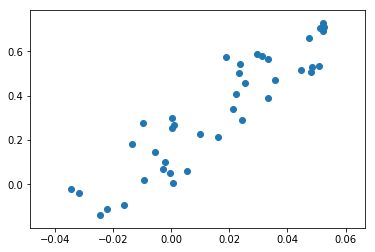

In [362]:
plt.scatter(right_pupil_centers_person[:, 0], right_gazes_true_person[:, 0])

In [360]:
i = 3

point_traces = [
    create_trace_3d(data.reshape(-1, 3), **marker_style) 
    for data in [translations[i],
#                  markers,
                 np.stack((left_pupil_centers[i], right_pupil_centers[i])), face_points_array[i], eye_centers_origin[i]]
]

line_left_traces = [
    create_trace_3d(np.stack((left_pupil_centers[i], left_pupil_centers[i]+left_gazes_true[i])), **line_style)
]
line_right_traces = [
    create_trace_3d(np.stack((right_pupil_centers[i], right_pupil_centers[i]+right_gazes_true[i])), **line_style)
]

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0), width=1000, height=1000)

fig = go.Figure(data=point_traces+line_right_traces, layout=layout) # +
iplot(fig, filename='simple-3d-scatter')

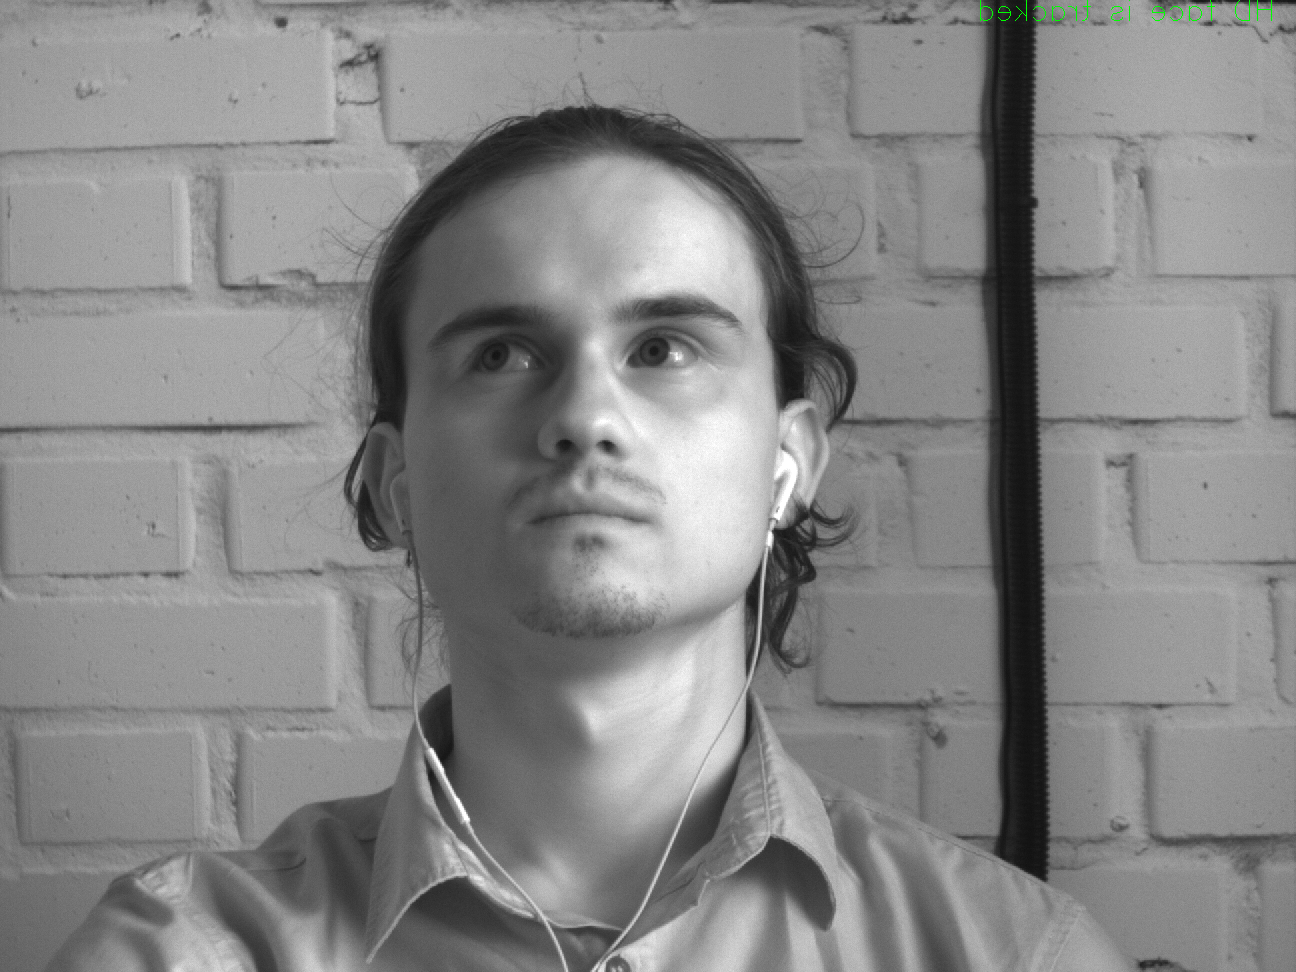

In [361]:
Image.fromarray(snapshots[i].InfraredCamera[:, ::-1, :])

In [ ]:
snapshots = [snapshot for snapshot in sess.snapshots_iterate(40)]

In [324]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

X = vecs2angles(right_pupil_centers_person)[:, 0].reshape(-1, 1)
Y = vecs2angles(right_gazes_true_person)[:, 0]

pipe = make_pipeline(Normalizer(), RandomForestRegressor())

kf = KFold(40)

for train_index, test_index in kf.split(X):
    
    # fit
    pipe.fit(X[train_index], Y[train_index])
    
    print('===========')
    print('score: ', pipe.score(X, Y))
    
    # test
    Y_pred = pipe.predict(X[test_index])
    print('train point: ', np.rad2deg(pipe.predict(X[train_index]) - Y[train_index]).mean(axis=0))
    print('test point: ', test_index, np.rad2deg(Y_pred - Y[test_index]))

score:  0.3749786184486794
train point:  0.775722820280433
test point:  [0] [96.53292865]
score:  0.37804327710042307
train point:  -0.07458997830469918
test point:  [1] [57.81450647]
score:  0.3773971192205987
train point:  1.871706486531942
test point:  [2] [-10.8257243]
score:  0.37784703868043723
train point:  -0.8264008824921181
test point:  [3] [-5.03437429]
score:  0.37739297074272815
train point:  -3.5751318946352044
test point:  [4] [69.10738558]
score:  0.3774135437368308
train point:  -2.686720021121637
test point:  [5] [42.75409752]
score:  0.3751386600790516
train point:  1.148623199695639
test point:  [6] [7.31139784]
score:  0.37852452266142045
train point:  -0.43089357388144395
test point:  [7] [-18.68777861]
score:  0.37844107255136816
train point:  0.041007934647795743
test point:  [8] [26.80691982]
score:  0.37830024338337864
train point:  -2.4006974561272854
test point:  [9] [72.83698149]
score:  0.37714453952122107
train point:  1.8758884576337669
test point:  [10]